In [1]:
import sys
sys.path.insert(0, '../')
from nn_cno import ode
import numpy as np
import itertools
import jax.numpy as jnp
import jax
import diffrax
import optax
import equinox as eqx 

### Summary

1. applying JIT on the simulation or cost function does not change the first time compilation time , however, it has effect on multiple evaluations
2. Running the simulation with RHS function defined inside the simulation takes long time. Seems that each evaluation requires compilation. However, if the simulation function is jitted, then multiple simulations are much faster. JIT-ing probably gives guarantee that the I/O data types are fixed and there is no need to recompile every time.



# Final attempt: minimal example


- improve the performance with one condition only. 

## Reference implementation
lets use the original implementation as reference. 
Note, it uses all conditions. 

It takes aprox 10.3-10.6 sec to compile the simulation function (without the gradient)

In [2]:
# load the network 
c = ode.logicODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "../nn_cno/datasets/working_case_study/MD-test.csv")
c.preprocessing()


In [3]:
%%timeit -n 1 -r 1
sim  = c.simulate()

9.94 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


First execution takes 10 sec

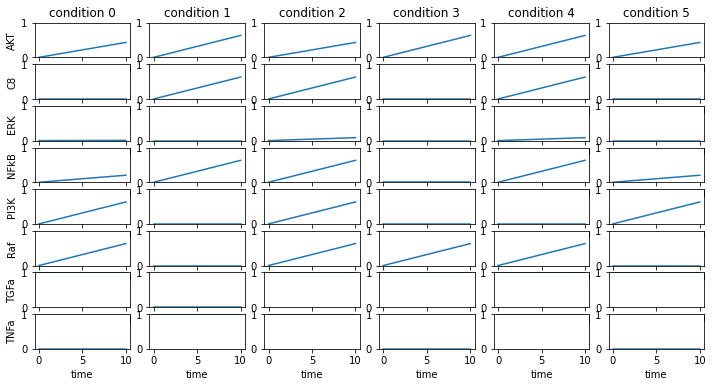

In [5]:
c.plot_simulation(c.simulate())

In [4]:
sim_reference = c.simulate()[0].ys

def check_solution(x):
    # assert that the x is numerically the same as sim_reference
    return(jnp.allclose(x, sim_reference))

In [16]:
%%timeit -n 1 -r 1
params = jnp.array(list(c.get_ODEparameters().values()))
loss_value, grads = jax.value_and_grad(c.loss_function)(params)

4min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


the first execution of the gradient took: 4 mins 38 sec

## Version 1:
-  the simulate function 


`simulate` must depend on 

In [109]:
# %%timeit -n 1 -r 1 # if this is running, then there is not result

i_condition = 0
#pars = jnp.asarray(list(c.ODEparameters.values()))
#pars = jnp.reshape(pars, newshape=(1,len(pars)))
pars = jnp.array(list(c.get_ODEparameters().values()))
f_jax = c.jax_model[0]
f_jax_p = c.jax_model[1] 
# y0 = jnp.asarray(list(c.conditions[i_condition]["y0"].values()))
# y0 = jnp.reshape(y0, newshape=(1,len(y0)))
y0 = jnp.array(list(c.conditions[i_condition]["y0"].values()))

def simulate(pars):
    def rhs_function( t, y, args):
        #X = jnp.concatenate([pars,y], axis=1)
        X = [*pars,*y]
        #dy = f_jax(X,f_jax_p)            
        dy = list()
        for i in range(len(y)):
            if f_jax[i] == 0:
                dy.append(jnp.array([0.0,])[0])
            else:
                dy.append(f_jax[i](jnp.array([X,]),f_jax_p[i])[0])

        return jnp.asarray(dy)

    ts = c.conditions[i_condition]["time"]
   

    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(rhs_function),
        diffrax.Heun(),
        ts[0],
        ts[-1],
        dt0=0.1,
        y0 = y0,
        stepsize_controller =diffrax.ConstantStepSize(),
        saveat=diffrax.SaveAt(ts=ts),
    )
    return(sol.ys)

def loss(params):
    # assure that parameters are within bounds for the simulation

    simulation_data = simulate(params)

        # extract the simulation data from the output of diffrax solution and subset it to the measured nodes. 
    simulation_df =  simulation_data[:,c.measurements_index]

    sq = jnp.power(simulation_df-c.measurements_df[0:2,:],2)
    mse = jnp.sum(sq)/jnp.size(sq)

    return mse

sim_v1 = simulate(pars)
sim_v1

DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 1.        , 0.        ],
             [0.429698  , 0.        , 0.00678881, 0.20241635, 0.63211405,
              0.63211405, 1.        , 0.        ]],            dtype=float32, weak_type=True)

Version 1 takes 2.6 sec 

In comparison to reference, this considers only 1 condition. 

In [63]:
check_solution(sim_v1)

DeviceArray(True, dtype=bool)

In [110]:
%%timeit -n 1 -r 1
mse = loss(pars)

2.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [111]:
%%timeit -n 1 -r 1
mse,grad_mse = jax.value_and_grad(loss)(pars)

54.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- 2.33 sec to compile the simulation  
- 53.4 sec to compile with gradient  

In [118]:
for _ in range(3):
# add random noise to the parameters
    pars_noise = pars + np.random.normal(0,1e-3,size=pars.shape)
    mse = loss(pars_noise)

## Version 2
jitting

In [82]:
# %%timeit -n 1 -r 1 # if this is running, then there is not result

i_condition = 0
#pars = jnp.asarray(list(c.ODEparameters.values()))
#pars = jnp.reshape(pars, newshape=(1,len(pars)))
pars = jnp.array(list(c.get_ODEparameters().values()))
f_jax = c.jax_model[0]
f_jax_p = c.jax_model[1] 
# y0 = jnp.asarray(list(c.conditions[i_condition]["y0"].values()))
# y0 = jnp.reshape(y0, newshape=(1,len(y0)))
y0 = jnp.array(list(c.conditions[i_condition]["y0"].values()))

@jax.jit
def simulate(pars):
    
    @jax.jit
    def rhs_function( t, y, args):
        #X = jnp.concatenate([pars,y], axis=1)
        X = [*pars,*y]
        #dy = f_jax(X,f_jax_p)            
        dy = list()
        for i in range(len(y)):
            if f_jax[i] == 0:
                dy.append(jnp.array([0.0,])[0])
            else:
                dy.append(f_jax[i](jnp.array([X,]),f_jax_p[i])[0])

        return jnp.asarray(dy)

    ts = c.conditions[i_condition]["time"]
   

    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(rhs_function),
        diffrax.Heun(),
        ts[0],
        ts[-1],
        dt0=0.1,
        y0 = y0,
        stepsize_controller =diffrax.ConstantStepSize(),
        saveat=diffrax.SaveAt(ts=ts),
    )
    return(sol.ys)

@jax.jit
def loss(params):
    # assure that parameters are within bounds for the simulation

    simulation_data = simulate(params)

        # extract the simulation data from the output of diffrax solution and subset it to the measured nodes. 
    simulation_df =  simulation_data[:,c.measurements_index]

    sq = jnp.power(simulation_df-c.measurements_df[0:2,:],2)
    mse = jnp.sum(sq)/jnp.size(sq)

    return mse

sim_v2 = simulate(pars)
sim_v2

DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 1.        , 0.        ],
             [0.429698  , 0.        , 0.00678881, 0.20241635, 0.63211405,
              0.63211405, 1.        , 0.        ]],            dtype=float32, weak_type=True)

1.87 sec to compile with jitted simulation and loss

In [79]:
check_solution(sim_v2)

DeviceArray(True, dtype=bool)

In [83]:
%%timeit -n 1 -r 1
mse = loss(pars)

1.95 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [84]:
%%timeit -n 1 -r 1
mse,grad_mse = jax.value_and_grad(loss)(pars)

54.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


without jitting the `rhs_function`: 
- 1.82 sec to compile the simulation  
- 51.1 sec to compile with gradient 

with jitting the `rhs_function`: 
- 1.95 sec to compile the simulation  
- 54.6 sec to compile with gradient 

## Version 3
passing all elements through the functions

In [102]:
#%%timeit -n 1 -r 1 # if this is running, then there is not result

i_condition = 0
#pars = jnp.asarray(list(c.ODEparameters.values()))
#pars = jnp.reshape(pars, newshape=(1,len(pars)))
pars = jnp.array(list(c.get_ODEparameters().values()))
f_jax = c.jax_model[0]
f_jax_p = c.jax_model[1] 
# y0 = jnp.asarray(list(c.conditions[i_condition]["y0"].values()))
# y0 = jnp.reshape(y0, newshape=(1,len(y0)))
y0 = jnp.array(list(c.conditions[i_condition]["y0"].values()))
condition = c.conditions[i_condition]
measurements_index = c.measurements_index
measurements_df = c.measurements_df

jax.jit
def simulate(pars, condition, f_jax, f_jax_p, y0):
    
    def rhs_function( t, y, args):
       
        X = [*pars,*y]
           
        dy = list()
        for i in range(len(y)):
            if f_jax[i] == 0:
                dy.append(jnp.array([0.0,])[0])
            else:
                dy.append(f_jax[i](jnp.array([X,]),f_jax_p[i])[0])

        return jnp.asarray(dy)

    ts = condition["time"]

    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(rhs_function),
        diffrax.Heun(),
        ts[0],
        ts[-1],
        dt0=0.1,
        y0 = y0,
        stepsize_controller =diffrax.ConstantStepSize(),
        saveat=diffrax.SaveAt(ts=ts),
    )
    return(sol.ys)

jax.jit
def loss(params,condition, f_jax, f_jax_p, y0,measurements_index, measurements_df):
    # assure that parameters are within bounds for the simulation

    simulation_data = simulate(params,condition, f_jax, f_jax_p, y0)

        # extract the simulation data from the output of diffrax solution and subset it to the measured nodes. 
    simulation_df =  simulation_data[:,measurements_index]

    sq = jnp.power(simulation_df-measurements_df[0:2,:],2)
    mse = jnp.sum(sq)/jnp.size(sq)

    return mse

sim_v3 = simulate(pars,condition, f_jax, f_jax_p, y0)
# loss_v3 = loss(pars,condition, f_jax, f_jax_p, y0,measurements_index, measurements_df)
#print(sim_v3)
#print(loss_v3)

2.0 sec to compile loss/simulation without jitting, but passing args. Also with jitting

In [105]:
%%timeit -n 1 -r 1
mse = loss(pars,condition, f_jax, f_jax_p, y0,measurements_index, measurements_df)

1.99 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [107]:
%%timeit -n 1 -r 1
mse,grad_mse = jax.value_and_grad(loss)(pars,condition, f_jax, f_jax_p, y0,measurements_index, measurements_df)

53.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


53 sec to compile with gradient. 

In [108]:
mse,grad_mse = jax.value_and_grad(loss)(pars,condition, f_jax, f_jax_p, y0,measurements_index, measurements_df)
grad_mse

DeviceArray([-0.01672585, -0.01634133, -0.31114155,  0.        ,
              0.        ,  0.        ,  0.00159976,  0.00309368,
              0.00083766,  0.00069839, -0.01471047, -0.00384081,
             -0.00358974,  0.        ,  0.        ,  0.05031369,
              0.        ,  0.        ,  0.38420588,  0.        ,
              0.        , -0.01587082], dtype=float32)

## Version 2 (jitting) with rearranged RHS

In [147]:
y0_array

[DeviceArray([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 DeviceArray([0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 DeviceArray([0., 0., 0., 0., 0., 0., 1., 1.], dtype=float32),
 DeviceArray([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 DeviceArray([0., 0., 0., 0., 0., 0., 1., 1.], dtype=float32),
 DeviceArray([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)]

In [146]:
# %%timeit -n 1 -r 1 # if this is running, then there is not result

i_condition = 0
pars = jnp.array(list(c.get_ODEparameters().values()))
f_jax = c.jax_model[0]
f_jax_p = c.jax_model[1] 
y0 = jnp.array(list(c.conditions[i_condition]["y0"].values()))
    
y0_array = [jnp.array(list(condi["y0"].values())) for condi in c.conditions]


@jax.jit
def simulate(pars):
    
    def rhs_function( t, y, args):  
        #X = jnp.concatenate([pars,y], axis=1)
        X = [*pars,*y]
        #dy = f_jax(X,f_jax_p)            
        dy = list()
        for i in range(len(y)):
            if f_jax[i] == 0:
                dy.append(jnp.array([0.0,])[0])
            else:
                dy.append(f_jax[i](jnp.array([X,]),f_jax_p[i])[0])

        return jnp.asarray(dy)
    
    ts = c.conditions[i_condition]["time"]

    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(rhs_function),
        diffrax.Heun(),
        ts[0],
        ts[-1],
        dt0=0.1,
        y0 = y0,
        stepsize_controller =diffrax.ConstantStepSize(),
        saveat=diffrax.SaveAt(ts=ts),
    )
    return(sol.ys)

@jax.jit
def loss(params):
    # assure that parameters are within bounds for the simulation

    v_sim = jax.vmap(simulate,in_axes=(None,0))
    simulation_data = simulate(params)

        # extract the simulation data from the output of diffrax solution and subset it to the measured nodes. 
    simulation_df =  simulation_data[:,c.measurements_index]

    sq = jnp.power(simulation_df-c.measurements_df[0:2,:],2)
    mse = jnp.sum(sq)/jnp.size(sq)

    return mse

sim_v2 = simulate(pars)
sim_v2

DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 1.        , 0.        ],
             [0.429698  , 0.        , 0.00678881, 0.20241635, 0.63211405,
              0.63211405, 1.        , 0.        ]],            dtype=float32, weak_type=True)

In [144]:
for _ in range(2):
# add random noise to the parameters
    pars_noise = pars + np.random.normal(0,1e-3,size=pars.shape)
    mse = loss(pars_noise)

## Vmap for conditions


In [191]:
from functools import partial

In [218]:
# %%timeit -n 1 -r 1 # if this is running, then there is not result

pars = jnp.array(list(c.get_ODEparameters().values()))
f_jax = c.jax_model[0]
f_jax_p = c.jax_model[1] 

# collect the initial conditions into a list of arrays: 
y0_list = [np.array(list(condi["y0"].values())) for condi in c.conditions]
y0_array = jnp.array(y0_list)

# Arrange the inhibited states per experiments into an array, which will allow to vmap across it. 
states = c.states
inhibited_list = list()
for i in range(len(c.conditions)):
    inhibited = np.zeros(len(states))
    for j in range(len(c.conditions[i]["inhibited"])):
        # indicate the index of the inhibited states
        inhibited[states.index(c.conditions[i]["inhibited"][j])] = 1
    inhibited_list.append(inhibited)
inhibited_list
inhibited_index_array = np.array(inhibited_list)


@jax.jit
def simulate(pars,y0,inhibited_states):
    
    @jax.jit
    def rhs_function( t, y, args):  
        X = [*pars,*y]
        dy = list()
        for i in range(len(y)):
            if f_jax[i] == 0:
                dy.append(jnp.array([0.0,])[0])
            else:
                dy.append((1.0-inhibited_states[i])*f_jax[i](jnp.array([X,]),f_jax_p[i])[0])

        return jnp.asarray(dy)
    
    ts = c.conditions[i_condition]["time"]

    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(rhs_function),
        diffrax.Heun(),
        ts[0],
        ts[-1],
        dt0=0.1,
        y0 = y0,
        stepsize_controller =diffrax.ConstantStepSize(),
        saveat=diffrax.SaveAt(ts=ts),
    )
    return(sol.ys)

simulate_all_map = jax.vmap(simulate,in_axes=(None,0,0))

@jax.jit
def loss(params):
    # assure that parameters are within bounds for the simulation

    #v_sim = jax.vmap(simulate,in_axes=(None,0))
    simulation_data = simulate_all_map(params,y0_array,inhibited_index_array)
    # extract the simulation data from the output of diffrax solution and subset it to the measured nodes. 
    simulation_df = jnp.concatenate([s[:,c.measurements_index] for s in simulation_data])

    #simulation_data = simulate(params,y0_list[0],inhibited_index_array[0])
    #simulation_df =  simulation_data[:,c.measurements_index]

    sq = jnp.power(simulation_df-c.measurements_df,2)
    mse = jnp.sum(sq)/jnp.size(sq)

    return mse


loss_v2, grad_loss = jax.value_and_grad(loss)(pars)


loss_v2

DeviceArray(0.1511962, dtype=float32)

In [6]:
c.midas.times

[0, 10]

In [213]:
simulation_data = simulate2_map(pars,y0_array,inhibited_index_array)
simulation_df = jnp.concatenate([s[:,c.measurements_index] for s in simulation_data])
simulation_df
loss_v2

DeviceArray(0.1511962, dtype=float32)

In [157]:
simulate(pars,y0_list[0])
simulate(pars,y0_list[1])
simulate(pars,y0_list[2])

DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 1.        , 1.        ],
             [0.429698  , 0.63211405, 0.08510416, 0.63211405, 0.63211405,
              0.63211405, 1.        , 1.        ]],            dtype=float32, weak_type=True)

In [162]:
# concatenate y0_list list into a matrix
y0_array = jnp.array(y0_list)
#j

In [164]:
simulate_map = jax.vmap(simulate,in_axes=(None,0))

In [165]:
simulate_map(pars,y0_array)

DeviceArray([[[0.        , 0.        , 0.        , 0.        ,
               0.        , 0.        , 1.        , 0.        ],
              [0.42969796, 0.        , 0.00678881, 0.2024164 ,
               0.63211423, 0.63211423, 1.        , 0.        ]],

             [[0.        , 0.        , 0.        , 0.        ,
               0.        , 0.        , 0.        , 1.        ],
              [0.63211423, 0.63211423, 0.        , 0.63211423,
               0.        , 0.        , 0.        , 1.        ]],

             [[0.        , 0.        , 0.        , 0.        ,
               0.        , 0.        , 1.        , 1.        ],
              [0.42969796, 0.63211423, 0.08510419, 0.63211423,
               0.63211423, 0.63211423, 1.        , 1.        ]],

             [[0.        , 0.        , 0.        , 0.        ,
               0.        , 0.        , 1.        , 0.        ],
              [0.42969796, 0.        , 0.00678881, 0.2024164 ,
               0.63211423, 0.63211423, 1. 

DeviceArray([[0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 1., 1.],
             [0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 1., 1.],
             [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [195]:
states = c.states
inhibited_list = list()
for i in range(len(c.conditions)):
    inhibited = np.zeros(len(states))
    for j in range(len(c.conditions[i]["inhibited"])):
        # indicate the index of the inhibited states
        inhibited[states.index(c.conditions[i]["inhibited"][j])] = 1
    inhibited_list.append(inhibited)
inhibited_list
inhibited_index_array = np.array(inhibited_list)
inhibited_index_array

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]])

In [229]:
def get_inhibited_species(self):
        
    inhibited = np.zeros((len(self.conditions),len(self.states)))
    print(inhibited.shape)
    for i in range(len(self.conditions)):
        
        for j in range(len(self.conditions[i]["inhibited"])):
            # indicate the index of the inhibited states
            
            inhibited[i,self.states.index(self.conditions[i]["inhibited"][j])] = 1


    return(inhibited)
get_inhibited_species(c)

(6, 8)


array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]])

In [196]:
inhibited_state = inhibited_index_array[0]
inhibited_state

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [224]:
c.midas.names_signals

array(['AKT', 'C8', 'ERK', 'NFkB'], dtype=object)

In [208]:
simulation_data = simulate2_map(pars,y0_array,inhibited_index_array)
simulation_df = jnp.concatenate([s[:,c.measurements_index] for s in simulation_data])
simulation_df

DeviceArray([[0.        , 0.        , 0.        , 0.        ],
             [0.42969796, 0.        , 0.00678881, 0.2024164 ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.63211423, 0.63211423, 0.        , 0.63211423],
             [0.        , 0.        , 0.        , 0.        ],
             [0.42969796, 0.63211423, 0.08510419, 0.63211423],
             [0.        , 0.        , 0.        , 0.        ],
             [0.63211423, 0.        , 0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        ],
             [0.63211423, 0.63211423, 0.08510419, 0.63211423],
             [0.        , 0.        , 0.        , 0.        ],
             [0.42969796, 0.        , 0.        , 0.2024164 ]],            dtype=float32, weak_type=True)

In [206]:
[s.ys for s in c.simulate()]

[DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
               0.        , 1.        , 0.        ],
              [0.429698  , 0.        , 0.00678881, 0.20241635, 0.63211405,
               0.63211405, 1.        , 0.        ]],            dtype=float32, weak_type=True),
 DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
               0.        , 0.        , 1.        ],
              [0.63211405, 0.63211405, 0.        , 0.63211405, 0.        ,
               0.        , 0.        , 1.        ]],            dtype=float32, weak_type=True),
 DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
               0.        , 1.        , 1.        ],
              [0.429698  , 0.63211405, 0.08510416, 0.63211405, 0.63211405,
               0.63211405, 1.        , 1.        ]],            dtype=float32, weak_type=True),
 DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
               0.        , 1.  